In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
import random
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [2]:
edges = pd.read_csv('facebook_large/edges.csv')


In [3]:
edges = pd.read_csv('facebook_large/edges.csv')

# renameing coulmn names
edges.set_axis(["User_1", "User_2"], axis='columns', inplace=True)

# dropping duplicate rows
edges.drop_duplicates(inplace=True)

# dropping rows where User_1 = User_2
edges.drop(edges[edges['User_1']==edges['User_2']].index, inplace=True)

# shuffle the data
edges = edges.sample(frac=1, random_state=1, ignore_index=True)
edges

,User_1,User_2
0,3256,16155
1,10231,12288
2,1387,9310
3,11244,15174
4,362,21907
...,...,...
170818,5458,13598
170819,9030,12252
170820,8606,17694
170821,326,11650


In [4]:
# chose between Graph() and DiGraph()
# I chose Graph here
G = nx.from_pandas_edgelist(edges, "User_1", "User_2", create_using = nx.Graph())

In [5]:
# number of edges
edge_num = len(G.edges)
# number of nodes
node_num = len(G.nodes)

print("Number of edges: ", edge_num, "\nNumber of nodes: ", node_num)

Number of edges:  170823 
Number of nodes:  22470


In [6]:
# creating a dictionary which key is a tuple of two nodes and values are 
# 1 or 0, depending if they are connected or not respectively
edge_dict = dict()

for index, row in edges.iterrows():
    edge_dict[(row["User_1"], row["User_2"])] = 1
    
missing_edges = set()
while len(missing_edges) < edge_num:
    # creating random start and end nodes 
    st_node = random.randint(1, node_num)
    en_node = random.randint(1, node_num)
    
    # assigning value 0 to edge, if it doesn't exist in our dictionary
    # else it is 1, as it takes the value from dictionary
    
    # for undirected Graph
    if edge_dict.get((st_node, en_node)) or edge_dict.get((en_node, st_node)):
        edge = 1
    else:
        edge = 0
        
    # for directed Greaph
    ## edge = edge_dict.get((st_node, en_node), 0)
    
    # checking if there is no edge, and it is not a self loop
    if edge == 0 and  st_node != en_node:
        try:
            # add points to the missing ones if the distance is greater than 2
            if nx.shortest_path_length(G, source=st_node, target=en_node) > 2:
                missing_edges.add((st_node, en_node))
        # if there is no path from st_node to en_node
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            missing_edges.add((st_node, en_node))
    

## Features

1. Common Neoghbors 
2. Jacard Coefficient
3. Resource Allocation
4. Adamic Adar INdex
5. Preferential Attachement
6. Shortest Path


In [8]:
# creating a datafram with edges that doesn't exist
no_edges = pd.DataFrame(list(missing_edges), columns=["User_1", "User_2"])

# train test split for existing edges
x_train_yes, x_test_yes, y_train_yes, y_test_yes = tts(edges,
                                                      np.ones(len(edges)),
                                                      train_size=0.8,
                                                      random_state=75)

# train test split for non existing edges
x_train_no, x_test_no, y_train_no, y_test_no = tts(no_edges,
                                                  np.zeros(len(no_edges)),
                                                  train_size=0.8,
                                                  random_state=75)


print("Number of edges of train data for existing ones", x_train_yes.shape[0], " and ", y_train_yes.shape[0])
print("Number of edges of test data for existing ones", x_test_yes.shape[0], " and ", y_test_yes.shape[0])
print("\b")
print("Number of edges of train data for non existing ones", x_train_no.shape[0], " and ", y_train_no.shape[0])
print("Number of edges of test data for nonexisting ones", x_test_no.shape[0], " and ", y_test_no.shape[0])

Number of edges of train data for existing ones 136658  and  136658
Number of edges of test data for existing ones 34165  and  34165

Number of edges of train data for non existing ones 136658  and  136658
Number of edges of test data for nonexisting ones 34165  and  34165


In [9]:
# creating a graph from train dataset with edges
G_train = nx.from_pandas_edgelist(x_train_yes, "User_1", "User_2", create_using = nx.Graph())

In [10]:
# index column shows the connection
# 1: there is an edge, 0: there is no edge
x_train_yes['index'] = 1
x_train_no['index'] = 0

x_test_yes['index'] = 1
x_test_no['index'] = 0

In [11]:
# combining train and test data for existing and non existing edges
# x's are dataframes
x_train = pd.concat([x_train_yes, x_train_no], ignore_index=True)
x_test = pd.concat([x_test_yes, x_test_no], ignore_index=True)


# shuffling train and test datasets
x_train = x_train.sample(frac=1, random_state=5, ignore_index=True)
x_test = x_test.sample(frac=1, random_state=5, ignore_index=True)
x_train

,User_1,User_2,index
0,9826,774,0
1,10070,11712,0
2,983,17402,1
3,11213,4318,0
4,19101,4012,0
...,...,...,...
273311,5298,14782,1
273312,1180,13145,0
273313,16726,18025,1
273314,7108,22230,1


In [12]:
x_test

,User_1,User_2,index
0,4689,12464,1
1,508,20722,1
2,16436,9364,0
3,3523,10543,1
4,17178,8669,0
...,...,...,...
68325,1435,13680,0
68326,16309,17194,1
68327,2673,21254,1
68328,1025,2334,1


In [13]:
# Page Rank
page_rank = nx.pagerank(G_train)
pr_mean = sum(page_rank.values())/len(page_rank)

print('min',page_rank[min(page_rank, key=page_rank.get)])
print('max',page_rank[max(page_rank, key=page_rank.get)])
print('mean',float(sum(page_rank.values())) / len(page_rank))

min 8.037431709960894e-06
max 0.001279768782271185
mean 4.583161464778391e-05


In [14]:
# calculating shortes path without considering the connection between nodes
def shortes_path(start, end):
    try:
        if G_train.has_edge(start, end):
            # removing existing edge 
            G_train.remove_edge(start, end)
            path = nx.shortest_path_length(G_train, start, end)
        else:
            path = nx.shortest_path_length(G_train, start, end)
        
        return path
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return 0

In [15]:
def common_neighbours(start, end):
    try:
        com_n = len(sorted(nx.common_neighbors(G_train, start, end)))
        return com_n
    except nx.NetworkXError:
        return -1

In [16]:
def jaccard_coef(start, end):
    if G_train.has_node(start) and G_train.has_node(end):
        coef = sorted(nx.jaccard_coefficient(G_train, [(start, end)]))[0][2]
        return coef
    else:
        return -1

In [17]:
def reso_alloc(start, end):
    if G_train.has_node(start) and G_train.has_node(end):
        coef = sorted(nx.resource_allocation_index(G_train, [(start, end)]))[0][2]
        return coef
    else:
        return -1

In [18]:
def adamic_adar(start, end):
    if G_train.has_node(start) and G_train.has_node(end):
        coef = sorted(nx.adamic_adar_index(G_train, [(start, end)]))[0][2]
        return coef
    else:
        return -1

In [19]:
def pref_attach(start, end):
    if G_train.has_node(start) and G_train.has_node(end):
        coef = sorted(nx.preferential_attachment(G_train, [(start, end)]))[0][2]
        return coef
    else:
        return -1

In [21]:
def calculate_feature(df):
    # Shortest Path
    df['shortes_path'] = df.apply(lambda row: shortes_path(row['User_1'], row['User_2']), axis=1)
    
    # Common Neighbors
    df['comm_neigh'] = df.apply(lambda row: common_neighbours(row['User_1'], row['User_2']), axis=1)

    # Jaccard Coefficient
    df['Jac_coef'] = df.apply(lambda row: jaccard_coef(row['User_1'], row['User_2']), axis=1)

    # Resource Allocation
    df['Res_alloc'] = df.apply(lambda row: reso_alloc(row['User_1'], row['User_2']), axis=1)

    # Adamic Adar Index
    df['Adam_adar'] = df.apply(lambda row: adamic_adar(row['User_1'], row['User_2']), axis=1)

    # Preferencial Attachment
    df['Pref_att'] = df.apply(lambda row: pref_attach(row['User_1'], row['User_2']), axis=1)

    # Page ranks
    df['page_rank_1'] = df['User_1'].apply(lambda x: page_rank.get(x, pr_mean))
    df['page_rank_2'] = df['User_2'].apply(lambda x: page_rank.get(x, pr_mean))
    
    # df['katz_1'] = df['User_1'].apply(lambda x: katz.get(x, katz_mean))
    # df['katz_2'] = df['User_2'].apply(lambda x: katz.get(x, katz_mean))
    return df

In [22]:
x_train = calculate_feature(x_train)

In [23]:
x_train.head()

,User_1,User_2,index,shortes_path,comm_neigh,Jac_coef,Res_alloc,Adam_adar,Pref_att,page_rank_1,page_rank_2
0,9826,774,0,6,0,0,0,0,0,0.000093,0.000094
1,10070,11712,0,4,0,0,0,0,0,0.000062,0.000064
2,983,17402,1,2,0,0,0,0,0,0.000156,0.000244
3,11213,4318,0,5,0,0,0,0,0,0.000032,0.000015
4,19101,4012,0,4,0,0,0,0,0,0.000055,0.000058


In [24]:
x_train

,User_1,User_2,index,shortes_path,comm_neigh,Jac_coef,Res_alloc,Adam_adar,Pref_att,page_rank_1,page_rank_2
0,9826,774,0,6,0,0,0,0,0,0.000093,0.000094
1,10070,11712,0,4,0,0,0,0,0,0.000062,0.000064
2,983,17402,1,2,0,0,0,0,0,0.000156,0.000244
3,11213,4318,0,5,0,0,0,0,0,0.000032,0.000015
4,19101,4012,0,4,0,0,0,0,0,0.000055,0.000058
...,...,...,...,...,...,...,...,...,...,...,...
273311,5298,14782,1,0,0,0,0,0,0,0.000040,0.000108
273312,1180,13145,0,0,0,0,0,0,0,0.000019,0.000016
273313,16726,18025,1,0,0,0,0,0,0,0.000088,0.000020
273314,7108,22230,1,0,0,0,0,0,0,0.000151,0.000103


In [25]:
x_test = calculate_feature(x_test)

In [26]:
x_test

,User_1,User_2,index,shortes_path,comm_neigh,Jac_coef,Res_alloc,Adam_adar,Pref_att,page_rank_1,page_rank_2
0,4689,12464,1,0,0,0,0,0,0,0.000082,0.000304
1,508,20722,1,0,0,0,0,0,0,0.000029,0.000020
2,16436,9364,0,0,0,0,0,0,0,0.000052,0.000051
3,3523,10543,1,0,0,0,0,0,0,0.000040,0.000112
4,17178,8669,0,0,0,0,0,0,0,0.000020,0.000299
...,...,...,...,...,...,...,...,...,...,...,...
68325,1435,13680,0,0,0,0,0,0,0,0.000016,0.000105
68326,16309,17194,1,0,0,0,0,0,0,0.000027,0.000099
68327,2673,21254,1,0,0,0,0,0,0,0.000088,0.000183
68328,1025,2334,1,0,0,0,0,0,0,0.000110,0.000033


## Use random forest classifyer

In [27]:
y_train = x_train['index']
y_test = x_test['index']

x_train = x_train.loc[:, x_train.columns != 'index']
x_test = x_test.iloc[:, x_test.columns != 'index']

In [28]:
x_train

,User_1,User_2,shortes_path,comm_neigh,Jac_coef,Res_alloc,Adam_adar,Pref_att,page_rank_1,page_rank_2
0,9826,774,6,0,0,0,0,0,0.000093,0.000094
1,10070,11712,4,0,0,0,0,0,0.000062,0.000064
2,983,17402,2,0,0,0,0,0,0.000156,0.000244
3,11213,4318,5,0,0,0,0,0,0.000032,0.000015
4,19101,4012,4,0,0,0,0,0,0.000055,0.000058
...,...,...,...,...,...,...,...,...,...,...
273311,5298,14782,0,0,0,0,0,0,0.000040,0.000108
273312,1180,13145,0,0,0,0,0,0,0.000019,0.000016
273313,16726,18025,0,0,0,0,0,0,0.000088,0.000020
273314,7108,22230,0,0,0,0,0,0,0.000151,0.000103


In [29]:
rfc = RandomForestClassifier(max_depth=15,
                            min_samples_leaf=30,
                            min_samples_split=100,
                            n_jobs=-1,
                            random_state=75)

rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

In [30]:
print('Test f1 score',f1_score(y_test,y_pred))

Test f1 score 0.7719039764265009


Text(0.5, 1.0, 'Confusion matrix')

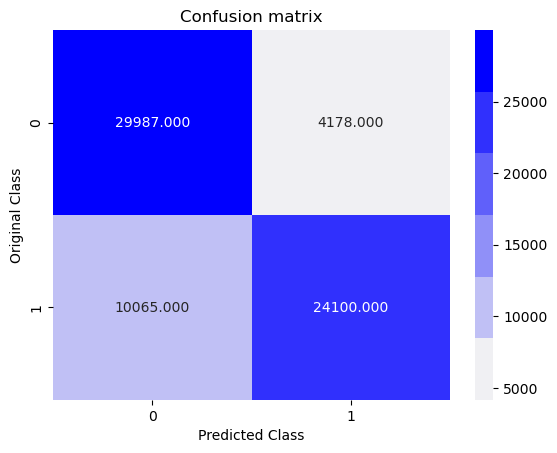

In [31]:
k = confusion_matrix(y_test, y_pred)
labels = [0,1]
cmap=sns.light_palette("blue")
sns.heatmap(k, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.title("Confusion matrix")